## Import thư viện

In [1]:
import torch
from torch import nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torchsummary
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import json
import os

## Model

In [2]:
class CNN(nn.Module):
    def __init__(self, image_size, out_channels, kernel_size, stride, padding, num_layers=2, num_blocks_per_layer=2, num_classes=100):
        super(CNN, self).__init__()
        self.in_channels = 3
        self.image_size = image_size
        self.layers = self.make_layer(num_layers, num_blocks_per_layer, out_channels, kernel_size=kernel_size, stride=stride, padding=padding, drop_out=0.5)
        self.flatten = nn.Flatten()
        self.image_size = image_size // (2 ** num_layers)
        self.fc = nn.Linear(self.image_size * self.image_size * self.in_channels, num_classes)

    def make_layer(self, num_layers, num_blocks_per_layer, out_channels, kernel_size, stride, padding, drop_out):
        layers = []
        for layer in range(num_layers):
            for block in range(num_blocks_per_layer):
                layers.extend([nn.Conv2d(self.in_channels, out_channels[layer], kernel_size, stride, padding),
                               nn.BatchNorm2d(out_channels[layer]),
                               nn.ReLU(inplace=True)])
                self.in_channels = out_channels[layer]
            layers.extend([nn.MaxPool2d(kernel_size=2),
                           nn.Dropout(drop_out)])
        return nn.Sequential(*layers)


    def forward(self, x):
        x = self.layers(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [3]:
model = CNN(32, [64, 128], 3, 1, 1)
x = torch.randn(5, 3, 32, 32)
torchsummary.summary(model)
out = model(x)
out.shape

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
|    └─MaxPool2d: 2-7                    --
|    └─Dropout: 2-8                      --
|    └─Conv2d: 2-9                       73,856
|    └─BatchNorm2d: 2-10                 256
|    └─ReLU: 2-11                        --
|    └─Conv2d: 2-12                      147,584
|    └─BatchNorm2d: 2-13                 256
|    └─ReLU: 2-14                        --
|    └─MaxPool2d: 2-15                   --
|    └─Dropout: 2-16                     --
├─Flatten: 1-2                           --
├─Linear: 1-3                            819,300
Total params: 1,080,228
Trainable params: 1,080,228
Non-trainable params: 0


torch.Size([5, 100])

## Cifar100

In [67]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Prepare data

In [68]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])


trainset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)

testset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


### Config

In [69]:
checkpoint_id = 1
folder_path = f'./CNN/Cifar100/checkpoint{checkpoint_id}/'
kernel_size = 3
stride = 1
padding = 1
image_size = 32
out_channels = [32, 64]
num_classes = len(trainset.classes)
batch_size = 256
num_epochs = 100
learning_rate = 0.001

os.makedirs(folder_path, exist_ok=True)

config = {
    "checkpoint_id": checkpoint_id,
    "folder_path": folder_path,
    "kernel_size": kernel_size,
    "stride": stride,
    "padding": padding,
    "image_size": image_size,
    "out_channels": out_channels,
    "num_classes": num_classes,
    "batch_size": batch_size,
    "num_epochs": num_epochs,
    "learning_rate": learning_rate
}

with open(folder_path + "config.json", "w") as f:
    json.dump(config, f, indent=4)

In [70]:
model = CNN(image_size, out_channels, kernel_size, stride, padding, num_classes=num_classes).to(device)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, steps_per_epoch=len(trainloader), epochs=num_epochs)
print(model)

CNN(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.5, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode

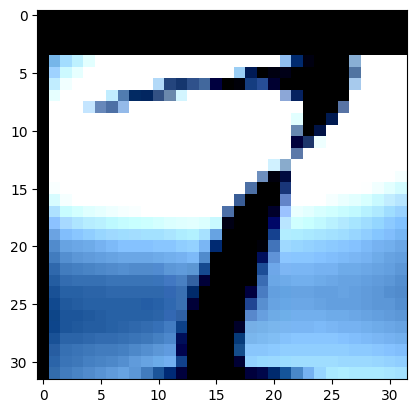

In [71]:
data_iter = iter(trainloader)
images, labels = next(data_iter)

image = images[0].permute(1, 2, 0).numpy()

plt.imshow(image)

In [72]:
print(f'Size: {image.shape}')
print(f'Train: {len(trainset)}')
print(f'Test: {len(testset)}')
print(f'Classes: {len(trainset.classes)}')

Size: (32, 32, 3)
Train: 50000
Test: 10000
Classes: 100


### Train, test

In [73]:
def train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=10):
    model.train()
    epoch_losses = []
    start = time.time()
    for epoch in tqdm(range(num_epochs)):
        running_loss = 0
        for i, (inputs, labels) in enumerate(trainloader, 0):
            # print(i)
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        running_loss = running_loss / len(trainloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        epoch_losses.append(running_loss)
        scheduler.step()
    end = time.time()
    training_time = (end - start) / 3600

    plt.plot(range(1, num_epochs + 1), epoch_losses)
    plt.title('Training Loss per Epoch')
    plt.suptitle(f'Training time: {training_time:.2f} hours')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.savefig(folder_path + 'training_loss.png')
    plt.show()

    torch.save(model.state_dict(), folder_path + 'model_weights.pth')

def evaluate(model, testloader, device, folder_path):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    correct = sum([1 for a, p in zip(all_labels, all_predictions) if a == p])
    total = len(all_labels)
    accuracy = 100 * correct / total
    report = classification_report(all_labels, all_predictions)
    print(f'Accuracy: {accuracy:.2f}%')
    print("Classification Report:")
    print(report)

    with open(folder_path + 'report.txt', "w") as f:
        f.write(f'Accuracy: {accuracy:.2f}%\n')
        f.write("Classification Report:\n\n")
        f.write(report)


  1%|          | 1/100 [00:27<44:52, 27.20s/it]

Epoch [1/100], Loss: 4.6238


  2%|▏         | 2/100 [00:53<43:18, 26.52s/it]

Epoch [2/100], Loss: 4.2176


  3%|▎         | 3/100 [01:19<42:44, 26.44s/it]

Epoch [3/100], Loss: 4.0395


  4%|▍         | 4/100 [01:45<42:14, 26.40s/it]

Epoch [4/100], Loss: 3.9220


  5%|▌         | 5/100 [02:12<41:39, 26.32s/it]

Epoch [5/100], Loss: 3.8307


  6%|▌         | 6/100 [02:38<41:11, 26.30s/it]

Epoch [6/100], Loss: 3.7456


  7%|▋         | 7/100 [03:04<40:45, 26.29s/it]

Epoch [7/100], Loss: 3.6698


  8%|▊         | 8/100 [03:31<40:40, 26.53s/it]

Epoch [8/100], Loss: 3.6095


  9%|▉         | 9/100 [03:57<40:01, 26.39s/it]

Epoch [9/100], Loss: 3.5413


 10%|█         | 10/100 [04:23<39:24, 26.27s/it]

Epoch [10/100], Loss: 3.4909


 11%|█         | 11/100 [04:49<38:55, 26.24s/it]

Epoch [11/100], Loss: 3.4523


 12%|█▏        | 12/100 [05:16<38:26, 26.21s/it]

Epoch [12/100], Loss: 3.4049


 13%|█▎        | 13/100 [05:41<37:51, 26.11s/it]

Epoch [13/100], Loss: 3.3780


 14%|█▍        | 14/100 [06:07<37:20, 26.05s/it]

Epoch [14/100], Loss: 3.3436


 15%|█▌        | 15/100 [06:33<36:47, 25.97s/it]

Epoch [15/100], Loss: 3.3059


 16%|█▌        | 16/100 [06:59<36:14, 25.88s/it]

Epoch [16/100], Loss: 3.2766


 17%|█▋        | 17/100 [07:25<35:43, 25.82s/it]

Epoch [17/100], Loss: 3.2532


 18%|█▊        | 18/100 [07:50<35:16, 25.81s/it]

Epoch [18/100], Loss: 3.2287


 19%|█▉        | 19/100 [08:17<35:11, 26.07s/it]

Epoch [19/100], Loss: 3.2002


 20%|██        | 20/100 [08:43<34:33, 25.91s/it]

Epoch [20/100], Loss: 3.1699


 21%|██        | 21/100 [09:08<34:03, 25.86s/it]

Epoch [21/100], Loss: 3.1508


 22%|██▏       | 22/100 [09:34<33:34, 25.83s/it]

Epoch [22/100], Loss: 3.1294


 23%|██▎       | 23/100 [10:00<33:06, 25.80s/it]

Epoch [23/100], Loss: 3.0971


 24%|██▍       | 24/100 [10:26<32:42, 25.82s/it]

Epoch [24/100], Loss: 3.0814


 25%|██▌       | 25/100 [10:51<32:11, 25.75s/it]

Epoch [25/100], Loss: 3.0598


 26%|██▌       | 26/100 [11:17<31:44, 25.73s/it]

Epoch [26/100], Loss: 3.0336


 27%|██▋       | 27/100 [11:43<31:21, 25.77s/it]

Epoch [27/100], Loss: 3.0118


 28%|██▊       | 28/100 [12:09<30:55, 25.77s/it]

Epoch [28/100], Loss: 2.9864


 29%|██▉       | 29/100 [12:34<30:31, 25.79s/it]

Epoch [29/100], Loss: 2.9633


 30%|███       | 30/100 [13:00<30:04, 25.78s/it]

Epoch [30/100], Loss: 2.9437


 31%|███       | 31/100 [13:27<30:00, 26.09s/it]

Epoch [31/100], Loss: 2.9187


 32%|███▏      | 32/100 [13:53<29:35, 26.11s/it]

Epoch [32/100], Loss: 2.9012


 33%|███▎      | 33/100 [14:19<29:11, 26.14s/it]

Epoch [33/100], Loss: 2.8814


 34%|███▍      | 34/100 [14:45<28:36, 26.01s/it]

Epoch [34/100], Loss: 2.8616


 35%|███▌      | 35/100 [15:11<28:12, 26.03s/it]

Epoch [35/100], Loss: 2.8471


 36%|███▌      | 36/100 [15:38<28:00, 26.26s/it]

Epoch [36/100], Loss: 2.8326


 37%|███▋      | 37/100 [16:04<27:30, 26.19s/it]

Epoch [37/100], Loss: 2.8158


 38%|███▊      | 38/100 [16:30<27:00, 26.13s/it]

Epoch [38/100], Loss: 2.7957


 39%|███▉      | 39/100 [16:56<26:30, 26.07s/it]

Epoch [39/100], Loss: 2.7848


 40%|████      | 40/100 [17:22<26:01, 26.02s/it]

Epoch [40/100], Loss: 2.7664


 41%|████      | 41/100 [17:48<25:33, 25.98s/it]

Epoch [41/100], Loss: 2.7565


 42%|████▏     | 42/100 [18:14<25:19, 26.20s/it]

Epoch [42/100], Loss: 2.7435


 43%|████▎     | 43/100 [18:41<24:53, 26.21s/it]

Epoch [43/100], Loss: 2.7241


 44%|████▍     | 44/100 [19:07<24:31, 26.27s/it]

Epoch [44/100], Loss: 2.7196


 45%|████▌     | 45/100 [19:33<24:00, 26.20s/it]

Epoch [45/100], Loss: 2.7060


 46%|████▌     | 46/100 [19:59<23:36, 26.22s/it]

Epoch [46/100], Loss: 2.6966


 47%|████▋     | 47/100 [20:26<23:14, 26.32s/it]

Epoch [47/100], Loss: 2.6720


 48%|████▊     | 48/100 [20:52<22:44, 26.24s/it]

Epoch [48/100], Loss: 2.6656


 49%|████▉     | 49/100 [21:18<22:18, 26.24s/it]

Epoch [49/100], Loss: 2.6602


 50%|█████     | 50/100 [21:44<21:53, 26.26s/it]

Epoch [50/100], Loss: 2.6421


 51%|█████     | 51/100 [22:11<21:29, 26.31s/it]

Epoch [51/100], Loss: 2.6392


 52%|█████▏    | 52/100 [22:37<21:01, 26.27s/it]

Epoch [52/100], Loss: 2.6253


 53%|█████▎    | 53/100 [23:03<20:34, 26.26s/it]

Epoch [53/100], Loss: 2.6156


 54%|█████▍    | 54/100 [23:30<20:20, 26.53s/it]

Epoch [54/100], Loss: 2.6143


 55%|█████▌    | 55/100 [23:57<19:52, 26.49s/it]

Epoch [55/100], Loss: 2.5991


 56%|█████▌    | 56/100 [24:23<19:24, 26.46s/it]

Epoch [56/100], Loss: 2.5826


 57%|█████▋    | 57/100 [24:50<18:55, 26.41s/it]

Epoch [57/100], Loss: 2.5718


 58%|█████▊    | 58/100 [25:16<18:27, 26.38s/it]

Epoch [58/100], Loss: 2.5710


 59%|█████▉    | 59/100 [25:42<18:03, 26.42s/it]

Epoch [59/100], Loss: 2.5578


 60%|██████    | 60/100 [26:09<17:38, 26.45s/it]

Epoch [60/100], Loss: 2.5506


 61%|██████    | 61/100 [26:35<17:13, 26.49s/it]

Epoch [61/100], Loss: 2.5416


 62%|██████▏   | 62/100 [27:02<16:45, 26.47s/it]

Epoch [62/100], Loss: 2.5387


 63%|██████▎   | 63/100 [27:28<16:15, 26.38s/it]

Epoch [63/100], Loss: 2.5295


 64%|██████▍   | 64/100 [27:54<15:48, 26.36s/it]

Epoch [64/100], Loss: 2.5151


 65%|██████▌   | 65/100 [28:22<15:32, 26.65s/it]

Epoch [65/100], Loss: 2.5160


 66%|██████▌   | 66/100 [28:48<15:02, 26.56s/it]

Epoch [66/100], Loss: 2.5058


 67%|██████▋   | 67/100 [29:14<14:35, 26.52s/it]

Epoch [67/100], Loss: 2.4947


 68%|██████▊   | 68/100 [29:41<14:06, 26.45s/it]

Epoch [68/100], Loss: 2.4898


 69%|██████▉   | 69/100 [30:07<13:36, 26.33s/it]

Epoch [69/100], Loss: 2.4805


 70%|███████   | 70/100 [30:33<13:07, 26.24s/it]

Epoch [70/100], Loss: 2.4765


 71%|███████   | 71/100 [30:59<12:43, 26.32s/it]

Epoch [71/100], Loss: 2.4677


 72%|███████▏  | 72/100 [31:26<12:17, 26.34s/it]

Epoch [72/100], Loss: 2.4585


 73%|███████▎  | 73/100 [31:52<11:51, 26.35s/it]

Epoch [73/100], Loss: 2.4575


 74%|███████▍  | 74/100 [32:19<11:27, 26.45s/it]

Epoch [74/100], Loss: 2.4443


 75%|███████▌  | 75/100 [32:45<10:59, 26.37s/it]

Epoch [75/100], Loss: 2.4426


 76%|███████▌  | 76/100 [33:12<10:37, 26.54s/it]

Epoch [76/100], Loss: 2.4339


 77%|███████▋  | 77/100 [33:38<10:07, 26.42s/it]

Epoch [77/100], Loss: 2.4270


 78%|███████▊  | 78/100 [34:05<09:41, 26.45s/it]

Epoch [78/100], Loss: 2.4265


 79%|███████▉  | 79/100 [34:31<09:13, 26.38s/it]

Epoch [79/100], Loss: 2.4097


 80%|████████  | 80/100 [34:57<08:45, 26.28s/it]

Epoch [80/100], Loss: 2.4098


 81%|████████  | 81/100 [35:23<08:17, 26.18s/it]

Epoch [81/100], Loss: 2.4068


 82%|████████▏ | 82/100 [35:49<07:50, 26.16s/it]

Epoch [82/100], Loss: 2.4032


 83%|████████▎ | 83/100 [36:15<07:24, 26.12s/it]

Epoch [83/100], Loss: 2.3932


 84%|████████▍ | 84/100 [36:41<06:57, 26.10s/it]

Epoch [84/100], Loss: 2.3862


 85%|████████▌ | 85/100 [37:07<06:30, 26.02s/it]

Epoch [85/100], Loss: 2.3823


 86%|████████▌ | 86/100 [37:33<06:03, 25.99s/it]

Epoch [86/100], Loss: 2.3752


 87%|████████▋ | 87/100 [38:00<05:41, 26.24s/it]

Epoch [87/100], Loss: 2.3749


 88%|████████▊ | 88/100 [38:26<05:13, 26.17s/it]

Epoch [88/100], Loss: 2.3594


 89%|████████▉ | 89/100 [38:52<04:47, 26.15s/it]

Epoch [89/100], Loss: 2.3587


 90%|█████████ | 90/100 [39:17<04:20, 26.06s/it]

Epoch [90/100], Loss: 2.3613


 91%|█████████ | 91/100 [39:43<03:53, 25.99s/it]

Epoch [91/100], Loss: 2.3479


 92%|█████████▏| 92/100 [40:09<03:27, 25.90s/it]

Epoch [92/100], Loss: 2.3502


 93%|█████████▎| 93/100 [40:35<03:00, 25.82s/it]

Epoch [93/100], Loss: 2.3411


 94%|█████████▍| 94/100 [41:01<02:35, 25.87s/it]

Epoch [94/100], Loss: 2.3332


 95%|█████████▌| 95/100 [41:26<02:09, 25.87s/it]

Epoch [95/100], Loss: 2.3331


 96%|█████████▌| 96/100 [41:52<01:43, 25.82s/it]

Epoch [96/100], Loss: 2.3322


 97%|█████████▋| 97/100 [42:18<01:17, 25.81s/it]

Epoch [97/100], Loss: 2.3230


 98%|█████████▊| 98/100 [42:44<00:51, 25.80s/it]

Epoch [98/100], Loss: 2.3140


 99%|█████████▉| 99/100 [43:10<00:26, 26.08s/it]

Epoch [99/100], Loss: 2.3137


100%|██████████| 100/100 [43:36<00:00, 26.17s/it]

Epoch [100/100], Loss: 2.3073


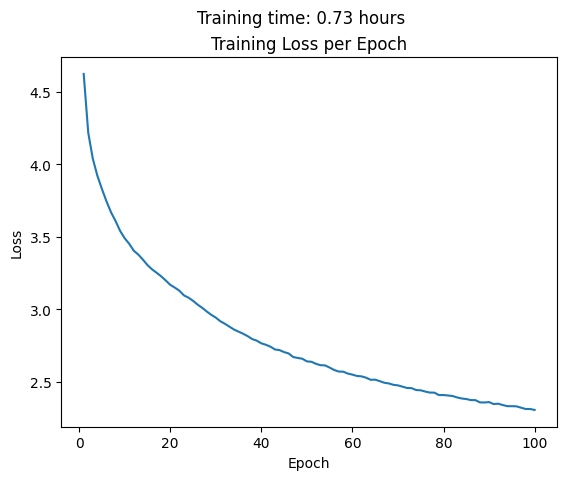

In [74]:
train(model, trainloader, criterion, optimizer, scheduler, device, folder_path, num_epochs=num_epochs)

In [75]:
evaluate(model, testloader, device, folder_path)

Accuracy: 47.00%
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.72      0.71       100
           1       0.59      0.50      0.54       100
           2       0.33      0.35      0.34       100
           3       0.22      0.17      0.19       100
           4       0.25      0.25      0.25       100
           5       0.37      0.48      0.42       100
           6       0.59      0.54      0.57       100
           7       0.41      0.47      0.44       100
           8       0.60      0.59      0.60       100
           9       0.63      0.61      0.62       100
          10       0.44      0.25      0.32       100
          11       0.34      0.24      0.28       100
          12       0.56      0.37      0.45       100
          13       0.53      0.30      0.38       100
          14       0.53      0.27      0.36       100
          15       0.43      0.30      0.35       100
          16       0.68      0.38      0.